In [1]:
import obspy 
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
import os
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
import time

### The purpose of this notebook is to - 

1) Compare the random forests model performance on the statistical features extraced using Tsfresh with that obtained using Absolute Fourier Spectrum (AFS) as features. 

2) We will extract the statistical features using tsfresh and store them. 

In [2]:
iq_lats = pd.read_csv('icequakes_catalog.csv')['latitude']
iq_lons = pd.read_csv('icequakes_catalog.csv')['longitude']

eq_lats = pd.read_csv('earthquakes_catalog.csv')['latitude']
eq_lons = pd.read_csv('earthquakes_catalog.csv')['longitude']

stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])


stations = stns.values[:,1].astype('str')
stn_lats = stns.values[:,2].astype('float')
stn_lons = stns.values[:,3].astype('float')
gl_lat, gl_lon = 61.219722, -146.895278

In [3]:
stns = pd.read_csv('gmap-stations.txt', sep='|', skiprows=[2,6])
stns

,#Network,Station,Latitude,Longitude,Elevation,Sitename,StartTime,EndTime
0,AK,BAE,61.131900,-148.123400,578.0,"Barry Arm East, AK, USA",2020-09-04T00:00:00,2599-12-31T23:59:59
1,AK,BAT,61.141600,-148.175100,1027.0,"Barry Arm Top, AK, USA",2021-07-23T00:00:00,2599-12-31T23:59:59
2,AK,BAW,61.150100,-148.150100,542.0,"Barry Arm West, AK, USA",2020-09-04T00:00:00,2021-04-30T23:59:59
3,AK,EYAK,60.548698,-145.750000,133.9,"Cordova Ski Area, AK, USA",2002-10-03T00:00:00,2599-12-31T23:59:59
4,AK,FID,60.727699,-146.598694,500.0,"Fidalgo, AK, USA",2010-07-26T00:00:00,2599-12-31T23:59:59
5,AK,GLI,60.879200,-147.095901,430.0,"Glacier Island, AK, USA",2010-07-26T00:00:00,2599-12-31T23:59:59
6,AK,HIN,60.396000,-146.503494,622.9,"Hinchinbrook, AK, USA",2009-11-01T00:00:00,2599-12-31T23:59:59
7,AK,KLU,61.492400,-145.922700,1047.1,"Klutina Pass, AK, USA",2008-09-13T00:00:00,2599-12-31T23:59:59
8,AK,KNK,61.413100,-148.458500,598.0,"Knik Glacier, AK, USA",2010-06-13T00:00:00,2599-12-31T23:59:59
9,AK,M23K,61.792900,-147.726200,583.0,"Glacier View, AK, USA",2020-04-17T00:00:00,2599-12-31T23:59:59


In [8]:
def load_dataset_spectrum(station, l=0, freq_band = None):
    '''station = station name
    l = [0,1,2] for [E,N,Z]
    freq_band = filter band to apply'''
    
    start_time = time.time()
    X1 = []
    for i in range(len(glob('Data/icequake_waveforms/*'+station+'*'))):
        st = obspy.read(glob('Data/icequake_waveforms/*'+station+'*')[i])
        if freq_band:
            st.filter(type='bandpass', freqmin=freq_band[0], freqmax=freq_band[1])
        if len(np.abs(np.fft.fft(st[l].data))) == 15000:
            X1.append(np.abs(np.fft.fft(st[l].data))/np.max(np.abs(np.fft.fft(st[l].data))))    
            
    X2 = []
    for i in range(len(glob('Data/earthquake_waveforms/*'+station+'*'))):
        st = obspy.read(glob('Data/earthquake_waveforms/*'+station+'*')[i])
        if freq_band:
            st.filter(type='bandpass', freqmin=freq_band[0], freqmax=freq_band[1])
        if len(np.abs(np.fft.fft(st[l].data))) == 15000:
            X2.append(np.abs(np.fft.fft(st[l].data))/np.max(np.abs(np.fft.fft(st[l].data))))   
            
            
    X = X1 +X2
    X = np.array(X)
    a = np.ones(len(X1))
    b = np.zeros(len(X2))
    c = np.concatenate([a,b])
    y = c        
    
    end_time = time.time()
    print(end_time-start_time)

    return X,y

def forest_test(X, Y, n_estimators= 50):
    X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, 
                                                        test_size = 0.20, 
                                                        random_state = 101)
    #X_train_fs, X_test_fs, fs = select_features(X_Train, Y_Train, X_Test)
    
    start = time.process_time()
    trainedforest = RandomForestClassifier(n_estimators=n_estimators).fit(X_Train,Y_Train)
    dur = time.process_time() - start
    predictionforest = trainedforest.predict(X_Test)
    #print(confusion_matrix(Y_Test,predictionforest))
    #print(classification_report(Y_Test,predictionforest))
    acc = accuracy_score(Y_Test, predictionforest)
    
    return acc

In [9]:
def load_dataset_tsfresh(station, l=0):
    X1 = []
    for i in range(len(glob('Data/icequake_waveforms/*'+station+'*'))):
        st = obspy.read(glob('Data/icequake_waveforms/*'+station+'*')[i])
        st.resample(10)
        if len(st[l].data) == 3000:
            X1.append(st[l].data)

    X2 = []
    for i in range(len(glob('Data/earthquake_waveforms/*'+station+'*'))):
        st = obspy.read(glob('Data/earthquake_waveforms/*'+station+'*')[i])
        st.resample(10)
        if len(st[l].data) == 3000:    
            X2.append(st[l].data)


    X = X1 +X2
    X = np.array(X)
    a = np.ones(len(X1))
    b = np.zeros(len(X2))
    c = np.concatenate([a,b])
    y = c 
    
    df = pd.DataFrame(X.transpose())
    df['time'] = st[0].times()
    df['id'] = np.zeros([np.shape(X)[1],1])
    df_features = extract_features(df,column_id = "id",column_sort="time", default_fc_parameters = EfficientFCParameters())    
    
    features = df_features.copy()
    new_features = pd.melt(features)
    Variables = new_features['variable'][0:783].values
    X_features = new_features['value'].values
    
    X_input = np.reshape(X_features, [np.shape(X)[0],783])
    
    return X_input,y

## Saving Features Extracted from Tsfresh

In [152]:
starttime = time.time()
for i in tqdm(range(len(stations))):
    X,y = load_dataset_tsfresh(stations[i], l=0)
    np.savetxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/tsfresh_features/"+stations[i]+".txt", X)
    np.savetxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/tsfresh_features/"+stations[i]+"_labels.txt", y)
endtime = time.time()

print("Total time taken:", endtime-starttime)    

Feature Extraction:   1%|█▊                                                                                                                                                 | 1/80 [00:33<43:58, 33.40s/it]


Feature Extraction:   7%|█████████▊                                                                                                                                         | 5/75 [00:29<03:50,  3.30s/it]


Feature Extraction:  18%|█████████████████████████▌                                                                                                                        | 14/80 [05:08<02:57,  2.69s/it]


Feature Extraction:  12%|██████████████████▎                                                                                                                               | 10/80 [03:30<03:50,  3.29s/it]


Feature Extraction:   8%|███████████                                                                                                                                        | 6/80 [04:32<21:40, 17.57s/it]


Feature Extraction:   6%|█████████▎                                                                                                                                         | 5/79 [04:21<30:48, 24.98s/it]


Feature Extraction:   4%|█████▍                                                                                                                                           | 3/80 [04:26<1:16:43, 59.78s/it]


 53%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 8/15 [2:26:57<2:50:46, 1463.74s/it]


Feature Extraction:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 78/80 [23:49<00:05,  2.85s/it]


Feature Extraction:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 76/79 [08:52<00:04,  1.38s/it]


Feature Extraction:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 76/80 [08:11<00:05,  1.41s/it]


Feature Extraction:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 73/79 [18:10<00:33,  5.59s/it]


Feature Extraction:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 71/80 [23:56<01:51, 12.44s/it]


Feature Extraction:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 68/80 [24:15<06:24, 32.08s/it]


Feature Extraction:  82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 66/80 [08:06<03:00, 12.89s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [4:52:05<00:00, 1168.36s/it]

Total time taken: 17525.355109214783


### It took around 5 hours to extract 783 features from each of the waveform considered. 

### Extracting Absolute Frequency Spectrum as Features. 

In [202]:
starttime = time.time()
for i in tqdm(range(len(stations))):
    X,y = load_dataset_spectrum(stations[i], l=0)
    np.savetxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/spectrum_features/"+stations[i]+".txt", X)
    np.savetxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/spectrum_features/"+stations[i]+"_labels.txt", y)
endtime = time.time()

print("Total time taken:", endtime-starttime)

  0%|                                                                                                                                                                               | 0/15 [00:00<?, ?it/s]

40.46273756027222


  7%|███████████▏                                                                                                                                                           | 1/15 [00:52<12:21, 52.99s/it]

30.937475442886353


 13%|██████████████████████▎                                                                                                                                                | 2/15 [01:32<09:47, 45.21s/it]

19.36884355545044


 20%|█████████████████████████████████▍                                                                                                                                     | 3/15 [01:58<07:16, 36.37s/it]

226.75124597549438


 27%|████████████████████████████████████████████▎                                                                                                                         | 4/15 [06:55<25:30, 139.17s/it]

159.9049849510193


 33%|███████████████████████████████████████████████████████▎                                                                                                              | 5/15 [10:28<27:37, 165.73s/it]

210.75847840309143


 40%|██████████████████████████████████████████████████████████████████▍                                                                                                   | 6/15 [14:59<30:15, 201.75s/it]

203.30353212356567


 47%|█████████████████████████████████████████████████████████████████████████████▍                                                                                        | 7/15 [19:24<29:39, 222.41s/it]

208.47454380989075


 53%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 8/15 [23:55<27:44, 237.83s/it]

217.10012769699097


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 9/15 [28:38<25:12, 252.02s/it]

82.05560731887817


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 10/15 [30:25<17:15, 207.00s/it]

77.07416081428528


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 11/15 [32:07<11:39, 174.98s/it]

164.09000444412231


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 12/15 [35:43<09:22, 187.46s/it]

214.33366990089417


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 13/15 [40:23<07:11, 215.52s/it]

223.05869817733765


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 14/15 [45:15<03:58, 238.64s/it]

78.15413022041321


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [46:56<00:00, 187.75s/it]

Total time taken: 2816.2112550735474


## It took just 47 Minutes!

## Computing the accuracies with features extracted using Tsfresh

In [6]:
starttime = time.time()
Acc_tsfresh = []
for j in tqdm(range(50)):
    acc_tsfresh = []
    for i in range(len(stations)):
        X = np.loadtxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/tsfresh_features/"+stations[i]+".txt")
        y = np.loadtxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/tsfresh_features/"+stations[i]+"_labels.txt")
    #    X = np.reshape(X[~np.isnan(X)],[len(y),round(np.shape(X[~np.isnan(X)])[0]/len(y))])  # Assuming each row contains equal number of NaN values
        X = np.delete(X, np.unique(np.where(np.isnan(X))[1]), axis=1)
        acc_tsfresh.append(forest_test(X,y))
    
    Acc_tsfresh.append(acc_tsfresh)
endtime = time.time()

print("Total time taken:", endtime-starttime)       

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [1:05:00<00:00, 78.00s/it]

Total time taken: 3900.0427107810974


In [30]:
Acc_tsfresh = np.array(Acc_tsfresh)
accuracy_tsfresh = np.mean(Acc_tsfresh, axis=0)

## Computing the accuracies with absolute spectrum values as features

In [21]:
starttime = time.time()
Acc_spectrum = []
for j in tqdm(range(50)):
    acc_spectrum = []
    for i in range(len(stations)):
        X = np.loadtxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/spectrum_features/"+stations[i]+".txt")
        y = np.loadtxt("/home/aakash/Desktop/Reference_Papers/Icequakes_Vs_Tectonicquakes/spectrum_features/"+stations[i]+"_labels.txt")
    #    X = np.reshape(X[~np.isnan(X)],[len(y),round(np.shape(X[~np.isnan(X)])[0]/len(y))])  # Assuming each row contains equal number of NaN values
    #    X = np.delete(X, np.unique(np.where(np.isnan(X))[1]), axis=1)
        acc_spectrum.append(forest_test(X,y))
    
    Acc_spectrum.append(acc_spectrum)
endtime = time.time()

print("Total time taken:", endtime-starttime)    
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [11:37:50<00:00, 837.40s/it]

Total time taken: 41870.21101164818


In [25]:
np.array(Acc_spectrum)

array([[ 0.84895833,  0.86330935,  0.82222222,  0.75390266,  0.95286624,
         0.9558676 ,  0.8401222 ,  0.94141013,  0.91729323,  0.87700535,
         0.87771739,  0.90145985,  0.94910462,  0.94444444,  0.79564033],
       [ 0.84895833,  0.87769784,  0.8       ,  0.7456382 ,  0.9477707 ,
         0.95486459,  0.83503055,  0.93445879,  0.91917293,  0.88770053,
         0.87771739,  0.89659367,  0.95004713,  0.94080146,  0.78201635],
       [ 0.85416667,  0.87769784,  0.82222222,  0.76033058,  0.95159236,
         0.95185557,  0.84826884,  0.94240318,  0.91447368,  0.88502674,
         0.88586957,  0.89416058,  0.95193214,  0.94262295,  0.78201635],
       [ 0.84375   ,  0.87769784,  0.81111111,  0.75206612,  0.95286624,
         0.95285858,  0.83401222,  0.93843098,  0.91165414,  0.89304813,
         0.88315217,  0.90389294,  0.94816211,  0.93897996,  0.78201635],
       [ 0.85416667,  0.84892086,  0.81111111,  0.74839302,  0.95159236,
         0.95185557,  0.83604888,  0.93843098, 

In [27]:
Acc_spectrum = np.array(Acc_spectrum)
accuracy_spectrum = np.mean(Acc_spectrum, axis=0)

In [29]:
accuracy_spectrum

array([ 0.8525    ,  0.87323741,  0.81088889,  0.7575023 ,  0.95090446,
        0.95402207,  0.84150713,  0.9388282 ,  0.91533835,  0.8871123 ,
        0.87956522,  0.89868613,  0.95089538,  0.94081967,  0.77923706])

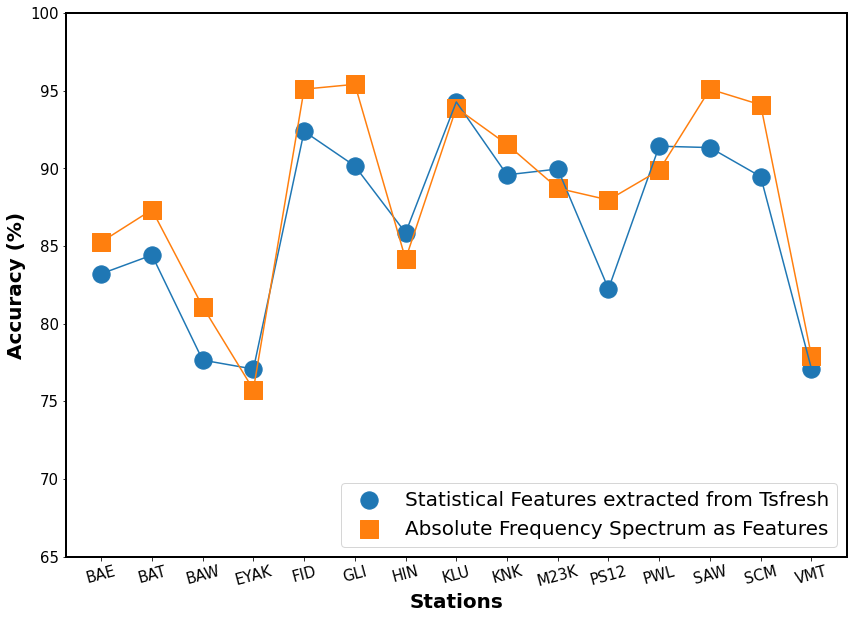

In [32]:
plt.rcParams['axes.linewidth'] = 2
fig, ax = plt.subplots(1,1,figsize=[14,10])
x = np.arange(15)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.scatter(x, np.array(accuracy_tsfresh)*100, s=300, label='Statistical Features extracted from Tsfresh')
ax.plot(x, np.array(accuracy_tsfresh)*100)

ax.scatter(x, np.array(accuracy_spectrum)*100, s=300, marker='s', label='Absolute Frequency Spectrum as Features')
ax.plot(x, np.array(accuracy_spectrum)*100)


ax.set_ylim(65, 100)
ax.set_xlabel('Stations', fontsize=20, weight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=20, weight='bold')
ax.set_xticks(x)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xticklabels(labels=stations, rotation=15, size=15)
ax.legend(loc = 'lower right', ncol=1, fontsize=20)

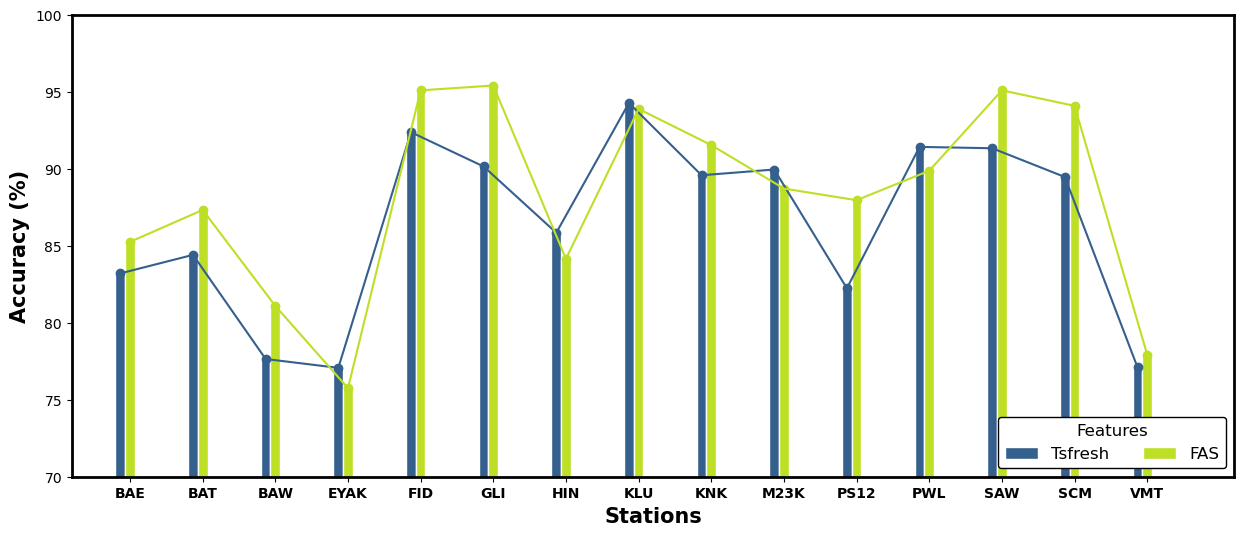

In [45]:

a1 = np.array(accuracy_tsfresh)*100
a2 = np.array(accuracy_spectrum)*100

plt.style.use('default')
plt.rcParams['axes.linewidth'] = 2
import numpy as np
import matplotlib.pyplot as plt


import matplotlib

cmap = matplotlib.cm.get_cmap('viridis')

c1 = cmap(0.1)
c2 = cmap(0.3)
c3 = cmap(0.5)
c4 = cmap(0.7)
c5 = cmap(0.9)
c6 = cmap(1.0)



# set width of bar
barWidth = 0.2
fig = plt.subplots(figsize =(15, 6), facecolor='white')
 



# Set position of bar on X axis
br1 = 1.5*np.arange(len(a1))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
br5 = [x + barWidth for x in br4]
br6 = [x + barWidth for x in br5]

# Make the plot
plt.bar(br1, a1, color =c2, width = barWidth,
        label ='Tsfresh',edgecolor='w')
plt.bar(br2, a2, color =c5, width = barWidth,
         label ='FAS',edgecolor='w')


v = np.vstack((a1,a2))
X = [br1, br2]
c= [c2,c5]
#for i in range(15):
#    plt.scatter(X[int(np.argmax(v[:,i]))][i], max(v[:,i])+0.5, c=c[int(np.argmax(v[:,i]))])


plt.scatter(br1, a1, color=c2)
plt.scatter(br2, a2, color=c5) 

plt.plot(br1, a1, color=c2)
plt.plot(br2, a2, color=c5) 

# Adding Xticks
plt.xlabel('Stations', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy (%)', fontweight ='bold', fontsize = 15)
plt.xticks([1.5*r + barWidth for r in range(len(a1))],stations, fontweight='black')
plt.ylim(70,100)
plt.xlim(-1,23)
plt.legend(loc='lower right',ncol=3, facecolor='white', framealpha=1, edgecolor='black', fontsize=12, title ='Features', title_fontsize=12)
#plt.show()

plt.savefig('Manuscript_Figures/Features_Performance_Comparison_averaged.eps')